# Explainable ML

A lot of this notebook with summarize Christoph Molnar's book, 
[Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/).
I highly recommend reading it in full if you haven't!

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing, load_iris
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 4)


'''
California Housing dataset
--------------------------
Features:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

A household is a group of people residing within a home. Since the average
number of rooms and bedrooms in this dataset are provided per household, these
columns may take surprisingly large values for block groups with few households
and many empty houses, such as vacation resorts.
'''
housing = fetch_california_housing()
housing_df = pd.DataFrame(housing['data'], columns=housing['feature_names'])
housing_df['y'] = housing['target']
housing_df.rename(columns={
    'MedInc': 'median_income',
    'HouseAge': 'median_house_age',
    'AveRooms': 'avg_rooms',
    'AveBedrms': 'avg_bedrooms',
    'Population': 'population',
    'AveOccup': 'avg_occup',
    'Latitude': 'lat',
    'Longitude': 'lon'
}, inplace=True)

'''
Iris plants dataset
--------------------
Iconic in the machine learning field. TIL that it originally comes from R.A Fisher in his paper published in Annual Eugenics.

The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  
One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.

Columns:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica
'''
iris = load_iris()
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
iris_df['y'] = iris['target']
iris_df.rename(columns={
    'sepal length (cm)': 'sepal_length',
    'sepal width (cm)': 'sepal_width',
    'petal length (cm)': 'petal_length',
    'petal width (cm)': 'petal_width'
}, inplace=True)

Add clusters to the housing dataset to categorize lat/lon locations.

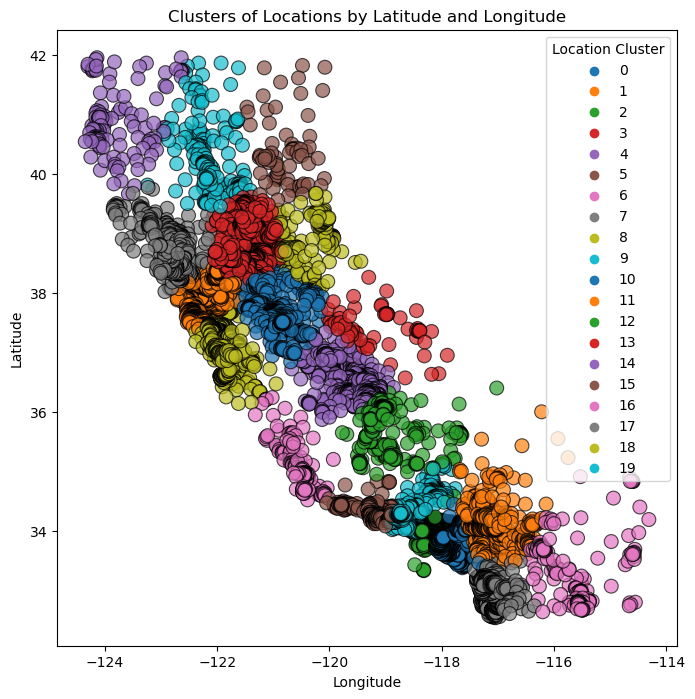

In [20]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(housing_df[['lat', 'lon']])
housing_df['location_cluster'] = kmeans.fit_predict(housing_df[['lat', 'lon']])
housing_df['location_cluster'] = housing_df['location_cluster'].astype('category')

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x='lon',
    y='lat',
    hue='location_cluster',
    palette='tab10',
    data=housing_df,
    s=100,
    alpha=0.7,
    edgecolor='black'
)
plt.title('Clusters of Locations by Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Location Cluster')
plt.show()

## Linear Regression
"You cannot really imagine a linear model with 5 features, because it would mean drawing the estimated hyperplane mentally in a 5-dimensional space. Any feature space with more than 3 dimensions is simply inconceivable for humans. Usually, when people try to comprehend a model, they consider only parts of it, such as the weights in linear models" 
[[1](https://christophm.github.io/interpretable-ml-book/scope-of-interpretability.html)].

All the interpretations always come with the footnote that "all other features remain the same". The estimated linear equation is a hyperplane in the feature/target space. The interpretation ignores the joint distribution of the features. Increasing one feature, but not changing another, can lead to unrealistic or at least unlikely data points [[1](https://christophm.github.io/interpretable-ml-book/limo.html)].

For example, switching location_clusters, but not latitude of longitude.

R-squared is a measure of how much of the variance of your target outcome is explained by the model. 
$$ R^2 = 1 - \frac{\text{Sum of Squared Errors}}{\text{Total Sum of Squares}} $$

Even better, Adjusted R-squared accounts for the number of features used in the model.
$$ \text{Adjusted } R^2 = 1 - (1-R^2) \frac{n-1}{n-p-1} $$

The t-statistic of a coefficient is found with:
<!-- $$ t_\beta^t_j $$ -->
<!-- $$ t_{\hat{\beta}}_j =  $$ -->
$$ \frac{\text{Estimated Coefficient}}{\text{Standard Error}({\text{True Coefficient}})} $$ 

Standard Error (SE) is the standard deviation of the sampling distribution of a statistic. It measures how much the estimated statistic (e.g., sample mean, regression coefficient) is expected to vary from sample to sample due to random sampling variability. Standard error is used to construct confidence intervals around an estimate to indicate the range within which the true population parameter is likely to lie.
$$ 95\% \text{ Confidence Interval:} = \text{Estimate} ± (Z×SE) $$

Z is the Z-score corresponding to the desired confidence level (1.96 for 95%)

In [51]:
model = sm.OLS(housing_df['y'], housing_df.drop('y', axis=1)).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                          1.901e+04
Date:                Sun, 06 Oct 2024   Prob (F-statistic):                        0.00
Time:                        08:21:39   Log-Likelihood:                         -24077.
No. Observations:               20640   AIC:                                  4.817e+04
Df Residuals:                   20631   BIC:                                  4.824e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [52]:
housing_df.iloc[:2]#.drop('y', axis=1)

,median_income,median_house_age,avg_rooms,avg_bedrooms,population,avg_occup,lat,lon,y,location_cluster
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526,1
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585,1


In [53]:
model.predict(housing_df.iloc[:2].drop('y', axis=1))

0    4.078903
1    3.865848
dtype: float64

Weight plots visualize the range of the estimated coefficients.

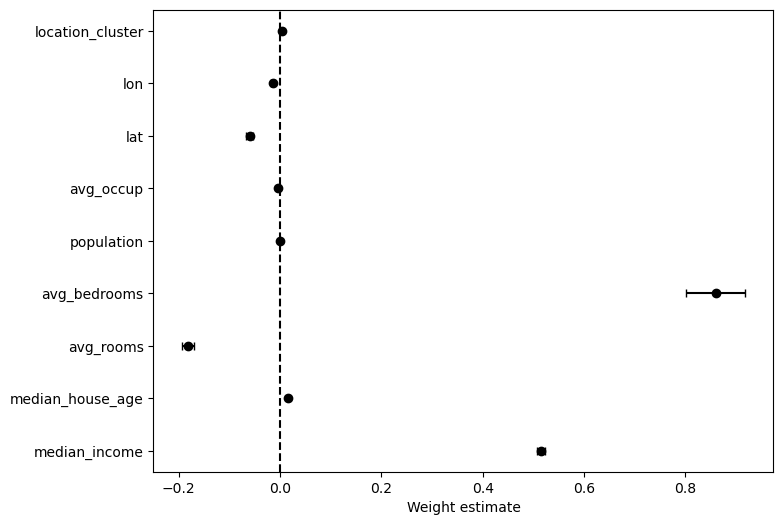

In [54]:
coef = model.params
conf = model.conf_int()
conf['coef'] = coef

# Plotting similar to the image provided
fig, ax = plt.subplots(figsize=(8, 6))

# Variables for plotting
var_names = conf.index
coef_vals = conf['coef'].values
error_bars = [(conf[1][i] - conf[0][i]) / 2 for i in range(len(conf))]

ax.errorbar(coef_vals, var_names, xerr=error_bars, fmt='o', color='black', ecolor='black', capsize=3)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Weight estimate')
ax.set_ylabel('')

plt.show()

Effect plots examine `feature weight` $*$ `feature value` to help visualize how much the combination contributes to the prediction.

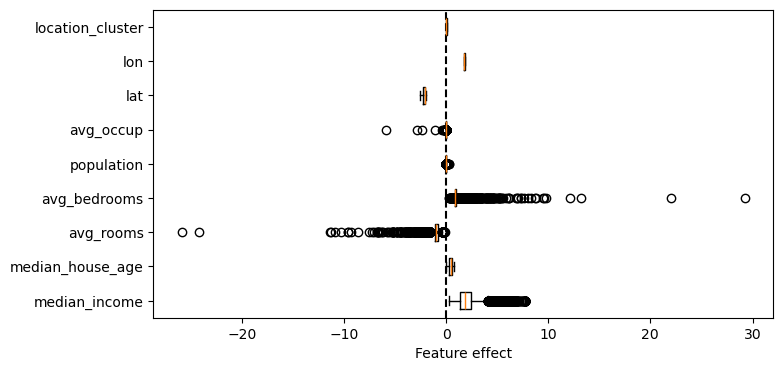

In [55]:
feature_effects = {
    feature: (housing_df[feature].to_numpy() * model.params[feature]) for feature in var_names
}

fig, ax = plt.subplots(figsize=(8, 4))

# Plotting boxplots for each feature
ax.boxplot([feature_effects[feature] for feature in var_names], vert=False, patch_artist=False)
ax.set_yticklabels(var_names)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Feature effect')

plt.show()

Now scaling the data, and adding a constant term.

In [26]:
from sklearn.preprocessing import StandardScaler

X = housing_df.drop('y', axis=1)  # Features (independent variables)
y = housing_df['y']  # Target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = sm.add_constant(X_scaled)
model = sm.OLS(y, X_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     3571.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        07:57:16   Log-Likelihood:                -22549.
No. Observations:               20640   AIC:                         4.512e+04
Df Residuals:                   20630   BIC:                         4.520e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0686      0.005    411.804      0.0

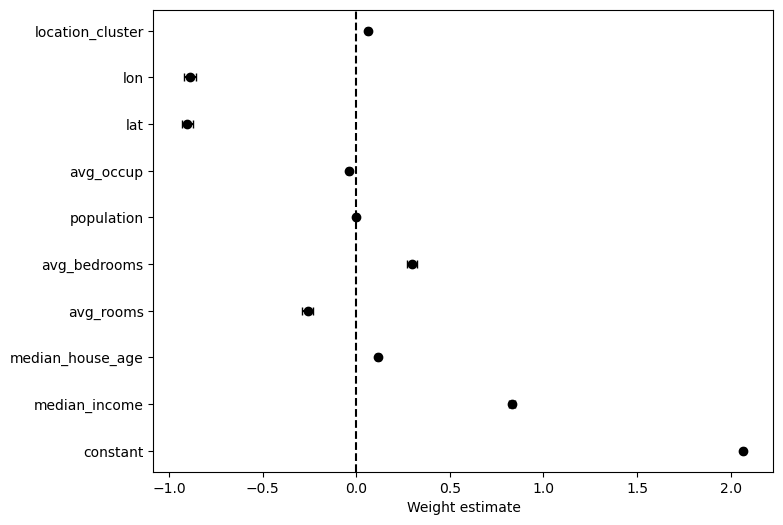

In [27]:
coef = model.params
conf = model.conf_int()
conf['coef'] = coef

# Plotting similar to the image provided
fig, ax = plt.subplots(figsize=(8, 6))

# Variables for plotting
var_names = ['constant'] + X.columns.to_list()#conf.index
coef_vals = conf['coef'].values
error_bars = [(conf[1][i] - conf[0][i]) / 2 for i in range(len(conf))]

ax.errorbar(coef_vals, var_names, xerr=error_bars, fmt='o', color='black', ecolor='black', capsize=3)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Weight estimate')
ax.set_ylabel('')

plt.show()

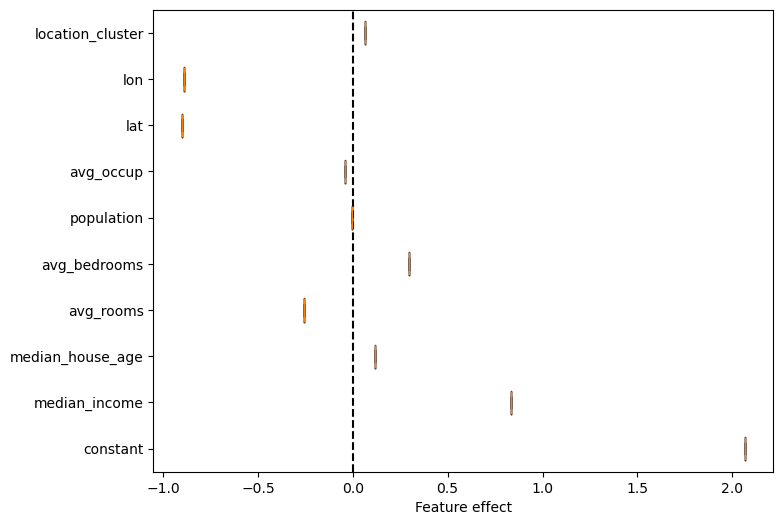

In [28]:
for i in range(0, len(var_names)):
    feature_effects[var_names[i]] = (X_scaled[:, 0] * model.params[i])

fig, ax = plt.subplots(figsize=(8, 6))

# Plotting boxplots for each feature
ax.boxplot([feature_effects[feature] for feature in var_names], vert=False, patch_artist=False)
ax.set_yticklabels(var_names)
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Feature effect')

plt.show()

## Logistic Regression
Very similar to linear regression except coefficients ``(coef)`` are estimates of the log-odds. For example, a coefficient of 2.13 for X means that for each one-unit increase in X, the log-odds of y=1 increase by approximately 2.13.

In [29]:
# Logistic regression can only handle 2 targets
subset_iris_df = iris_df[iris_df['y'].isin([0, 1])]

X = subset_iris_df.drop('y', axis=1)
y = subset_iris_df['y']

X_with_const = sm.add_constant(X)
logit_model = sm.Logit(y, X_with_const)
model = logit_model.fit()
print(model.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            4
Date:                Sun, 06 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        07:57:17   Log-Likelihood:            -8.9814e-06
converged:                      False   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 5.547e-29
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.6813    1.2e+04      0.001      0.999   -2.35e+04    2.35e+04
sepal_length    -4.1173   3316.583     -0.001      0.999   

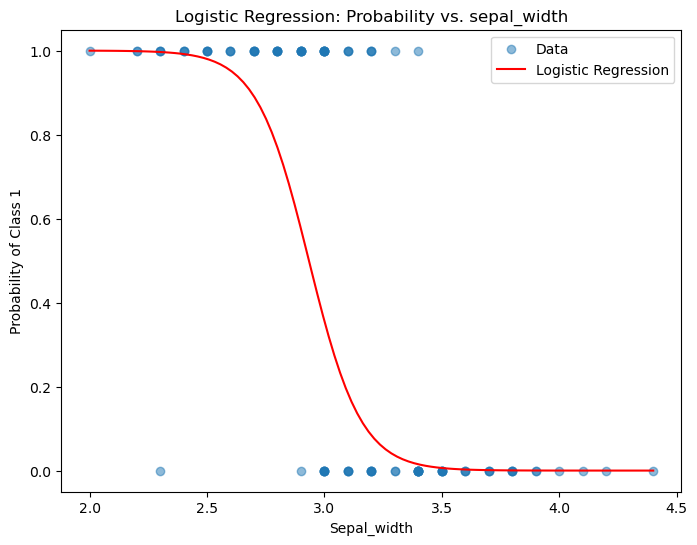

In [30]:
predictor = 'sepal_width'
X_plot = np.linspace(subset_iris_df[predictor].min(), subset_iris_df[predictor].max(), 100)
X_mean = subset_iris_df.drop('y', axis=1).mean()
X_pred = pd.DataFrame({
    'const': 1,  # Intercept
    'sepal_length': X_mean['sepal_length'],
    'sepal_width': X_plot,
    'petal_length': X_mean['petal_length'],
    'petal_width': X_mean['petal_width']
})
pred_probs = model.predict(X_pred)

plt.figure(figsize=(8, 6))
plt.scatter(subset_iris_df[predictor], y, label='Data', alpha=0.5)
plt.plot(X_plot, pred_probs, color='red', label='Logistic Regression')
plt.xlabel(predictor.capitalize())
plt.ylabel('Probability of Class 1')
plt.title(f'Logistic Regression: Probability vs. {predictor}')
plt.legend()
plt.show()

## Partial Dependence Plots
Shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 2001)

```{warning}
PDPs assume that features are not correlated.
```

For a feature $X_j$, the partial dependence function is defined as:
$$ f_{PD}(X_j) = \frac{1}{n} \sum_{i=1}^n f(X_j, X_{-j}^{(i)}) $$
Where:
- $f$ is the prediction function of the model
- $X_{-j}^{(i)}$ represents all features except

The sum averages the predictions over the dataset, varying $X_j$ while keeping other features fixed.

For classification where the ML model outputs probabilities, the PDP displays the probability for a certain class given different values for a feature.

## Shapley Values
Shapley Values distribute a model's prediction fairly across features based on their contribution.

## SHAP 
SHAP (SHapley Additive exPlanations) is a method to explain individual predictions based on the game theoretically optimal Shapley values.

[Docs](https://shap.readthedocs.io/en/latest/)


### Regression

### Binary Classification

### Multiclass Classification

In [98]:
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = iris_df.drop('y', axis=1)
y = iris_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "boosting_type": "dart",
    "objective": "multiclass",
    "num_classes": 3,
    "num_leaves": 31,
    "early_stopping_round": 50,
    "verbose": -1,
}

model = lgb.train(
    params,
    lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_test, label=y_test)],
)

explainer = shap.Explainer(model)
shap_values = explainer(X)

In [99]:
X.iloc[0, :]

sepal_length    5.1
sepal_width     3.5
petal_length    1.4
petal_width     0.2
Name: 0, dtype: float64

In [100]:
shap_values.shape

(150, 4, 3)

In [101]:
shap_values.values[1, :, 0]

array([ 0.00792637, -0.12846731,  2.50324771,  1.67212709])

In [113]:
explainer.expected_value

[-1.503795346946993, -1.0062223914213027, -1.4047610006721076]

In [102]:
X.iloc[0, :]

sepal_length    5.1
sepal_width     3.5
petal_length    1.4
petal_width     0.2
Name: 0, dtype: float64

In [110]:
shap.force_plot(explainer.expected_value[0], shap_values.values[1, :, 0], X.iloc[0, :])

In [111]:
shap.force_plot(explainer.expected_value[1], shap_values.values[1, :, 1], X.iloc[0, :])

In [112]:
shap.force_plot(explainer.expected_value[2], shap_values.values[1, :, 2], X.iloc[0, :])

In [107]:
for i in range(3):
    shap.force_plot(explainer.expected_value[i], shap_values.values[1, :, i], X.iloc[0, :])

In [95]:
shap.initjs()

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

model = lgb.train(
    params,
    d_train,
    10000,
    valid_sets=[d_test],
)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

shap.force_plot(explainer.expected_value, shap_values.values[1, :], X_display.iloc[0, :])

In [86]:
shap.force_plot(explainer.expected_value, shap_values.values[0, :], X.iloc[0, :])

In [70]:
X_display

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [71]:
X

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


In [62]:
y_display

array([False, False, False, ..., False, False,  True])

In [49]:
X_train

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
12011,51.0,4,10.0,0,6,0,4,0,0.0,0.0,40.0,21
23599,51.0,1,14.0,6,12,1,4,1,0.0,0.0,50.0,8
23603,21.0,4,11.0,4,3,3,2,1,0.0,0.0,40.0,39
6163,25.0,4,10.0,4,12,3,4,1,0.0,0.0,24.0,39
14883,48.0,4,13.0,0,1,3,4,1,0.0,0.0,38.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...
5699,23.0,4,9.0,4,12,0,4,1,0.0,0.0,40.0,39
10742,37.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
16921,27.0,6,5.0,2,3,4,4,1,0.0,0.0,40.0,39
25796,46.0,4,16.0,2,10,4,4,1,0.0,2415.0,55.0,39


In [48]:
X_display

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [45]:
shap.force_plot(explainer.expected_value, shap_values.values[:1000, :], X_display.iloc[:1000, :])

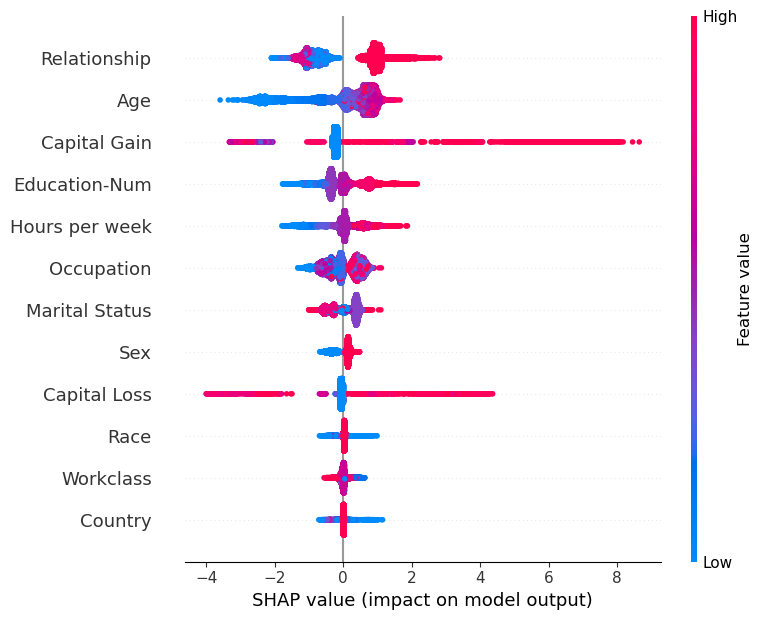

In [34]:
shap.summary_plot(shap_values, X)

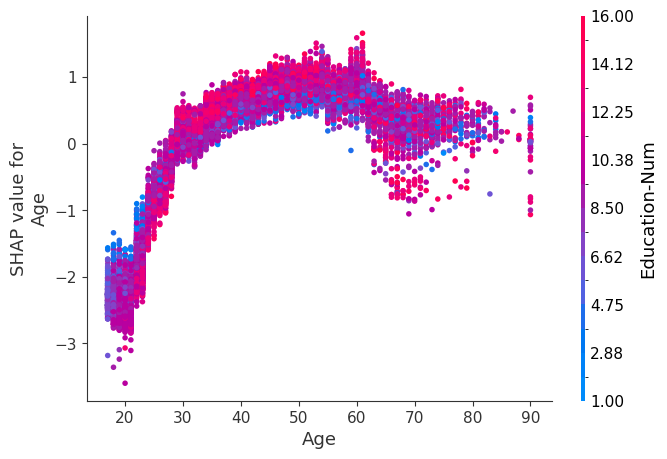

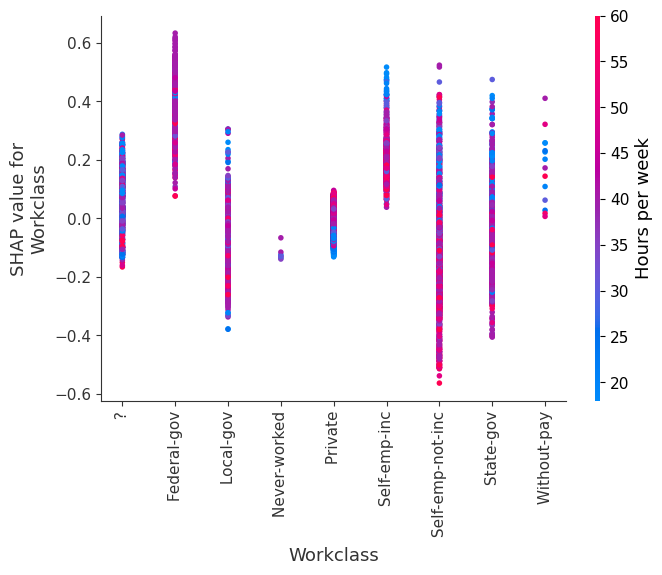

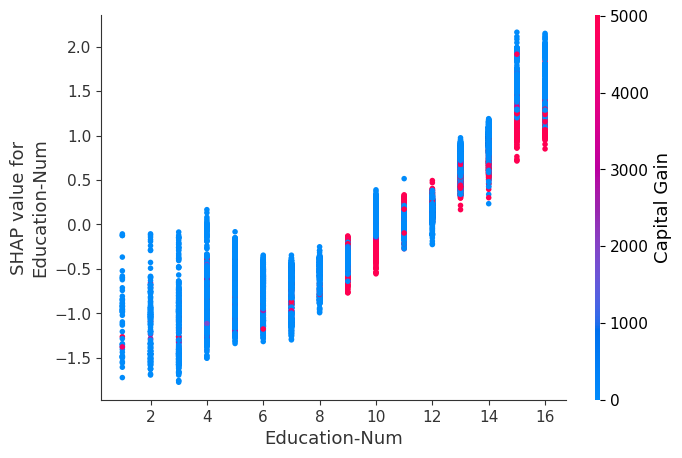

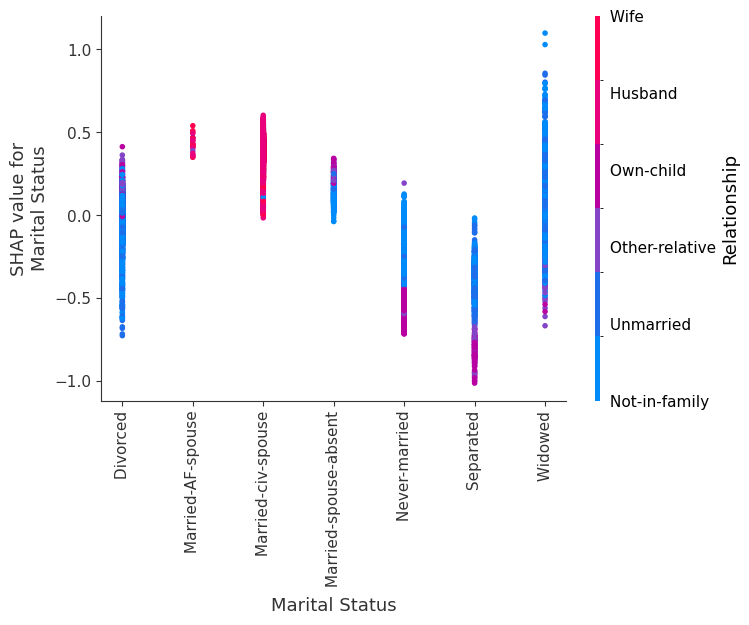

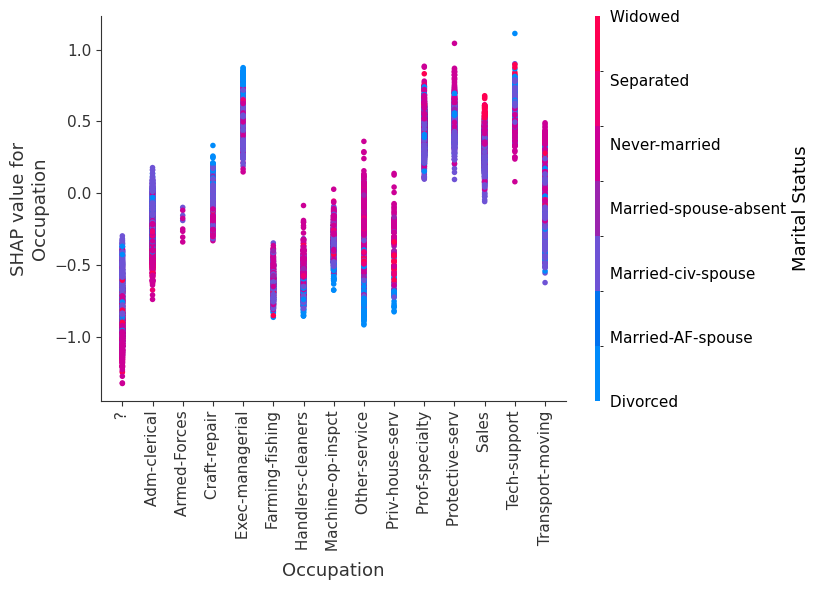

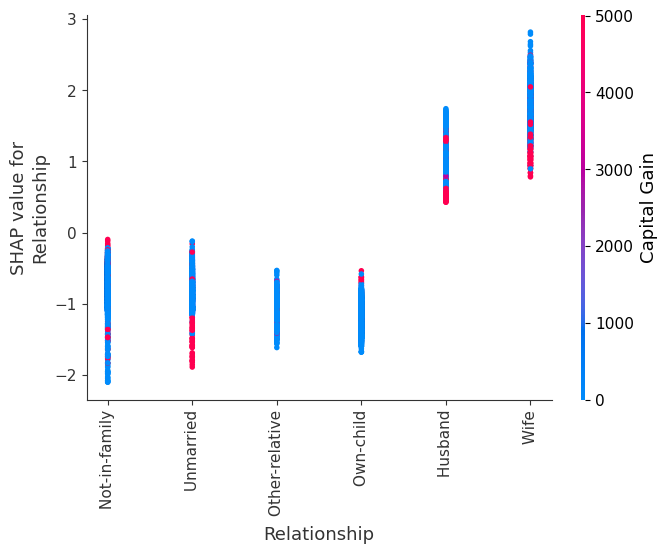

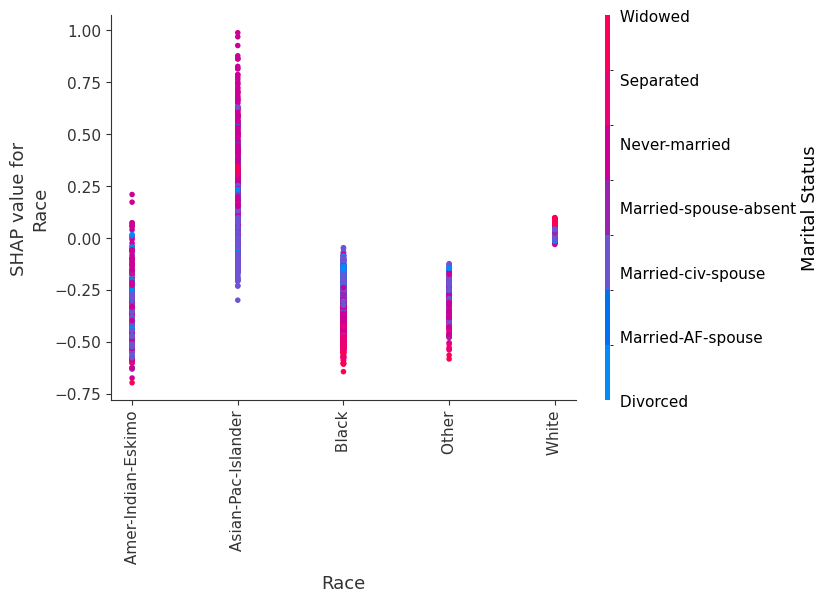

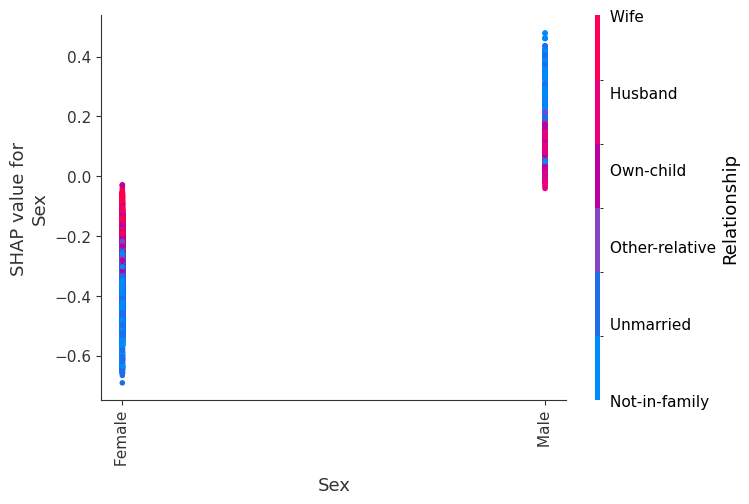

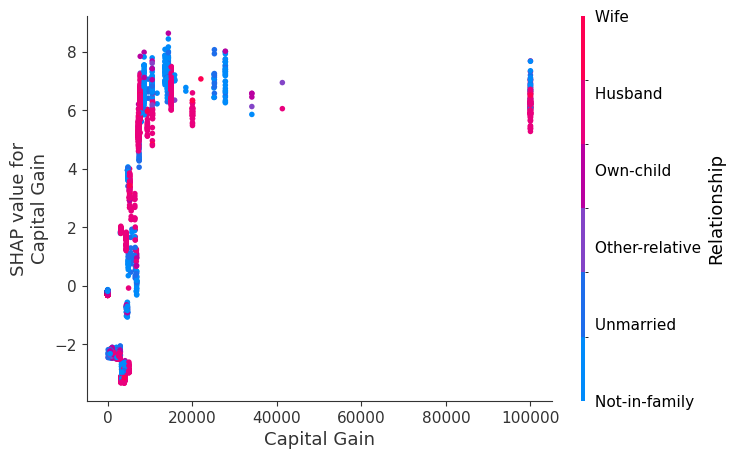

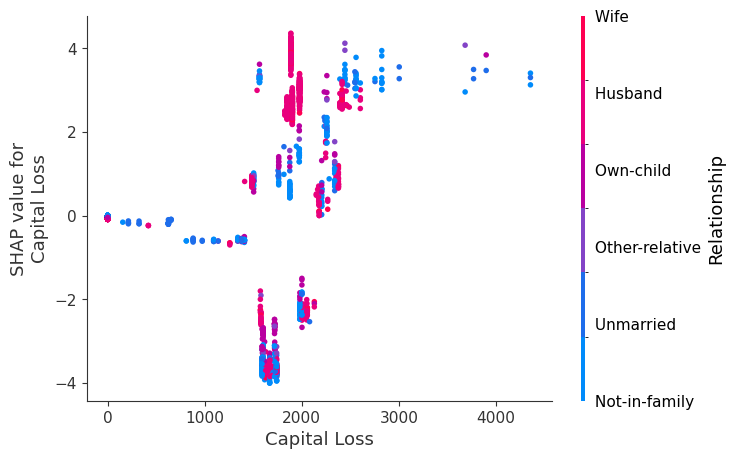

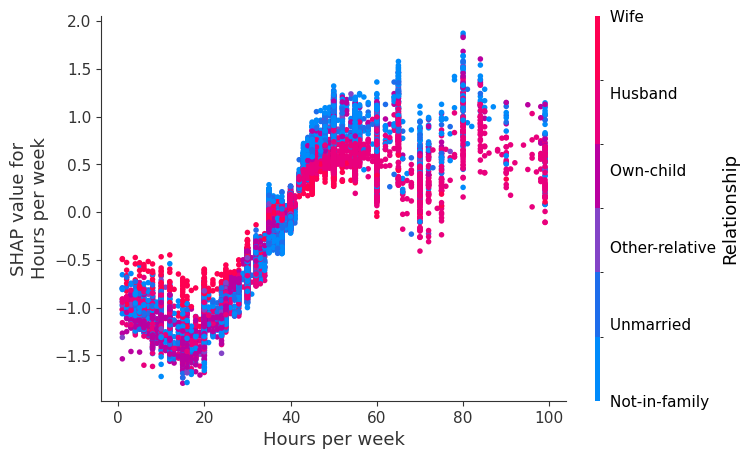

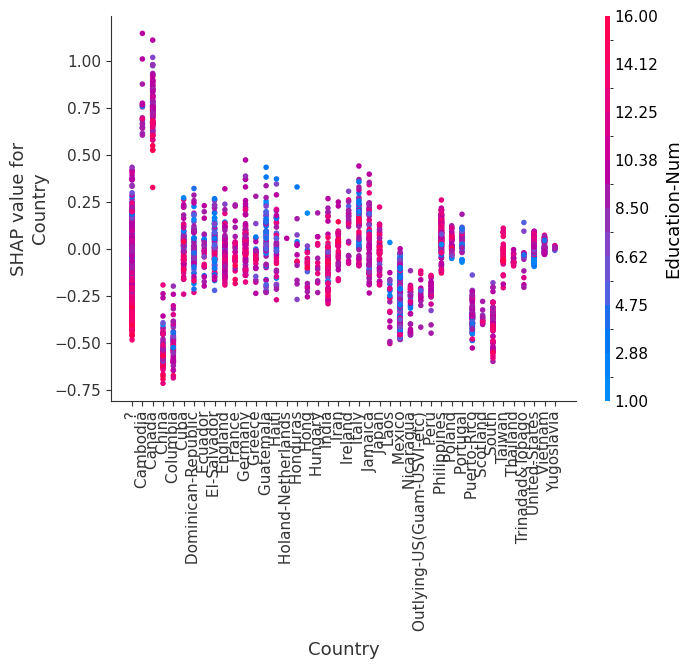

In [35]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values.values, X, display_features=X_display)

In [36]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names = explainer.data_feature_names)

AttributeError: 'TreeExplainer' object has no attribute 'data_feature_names'

In [78]:
X.iloc[0,:]

sepal_length    5.1
sepal_width     3.5
petal_length    1.4
petal_width     0.2
Name: 0, dtype: float64

In [76]:
shap.force_plot(explainer.expected_value[0], X.iloc[0,:])


ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [75]:
shap.plots.force(explainer.expected_value[0], shap_values)

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [65]:
X.iloc[0, :]

sepal_length    5.1
sepal_width     3.5
petal_length    1.4
petal_width     0.2
Name: 0, dtype: float64

In [67]:
shap_values.values[1, :]

array([[ 3.61620580e-03, -6.09922364e-01, -4.17469817e-01],
       [-7.62275961e-01, -2.74738397e-02, -1.90254210e-02],
       [ 4.87480319e+00, -1.91391028e+00, -1.56663595e+00],
       [ 3.72616947e+00, -6.79502778e-01, -1.09043187e+00]])

In [66]:
shap.force_plot(explainer.expected_value, )

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1200x400 with 0 Axes>

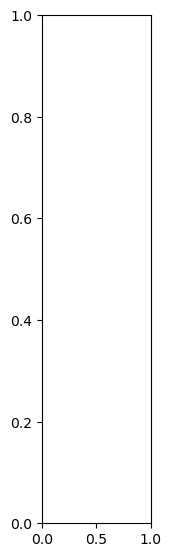

In [62]:
plt.figure()
shap.summary_plot(shap_values, X_test)
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1200x400 with 0 Axes>

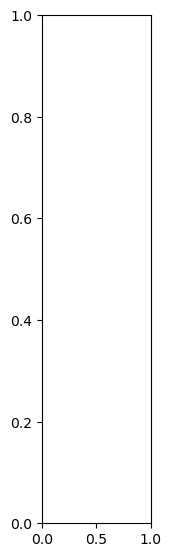

In [52]:
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

ValueError: x and y must be the same size

<Figure size 1200x400 with 0 Axes>

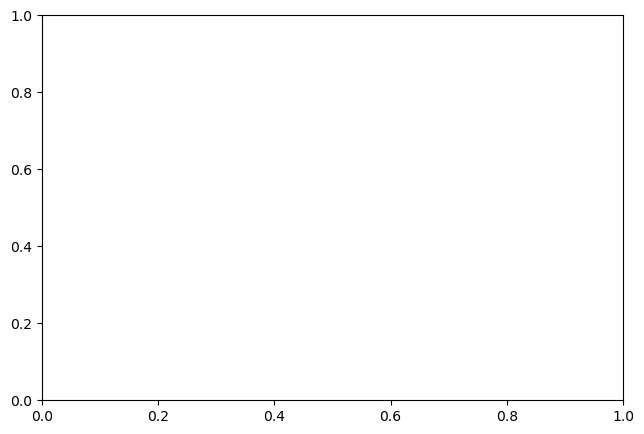

In [48]:
plt.figure()
shap.dependence_plot("petal_length", shap_values.values, X_test)
plt.show()

In [49]:
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0], matplotlib=True)


TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).